# build_compilation notebook

This notebook iterates through each paleomagnetic record (datasheet) of the vgp database, extracts data which meet user-specified criteria, and appends them to a new dataframe for later processing (to generate an APWP).

In [1]:
import os
import re
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import scripts.auxiliar as aux
from scripts.utils_compilation import split_datasheet, recalc_vgps, go_reverse, get_k, get_alpha95


import seaborn as sns

pd.set_option('display.max_columns', None)

Set the directory from which we will pull the datasheets.

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/vgp_database'
files_names = aux.get_files_in_directory(data_path_VGP)
#csv_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.csv')] #consider just *csv files
xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')]
paths = [file for file in files_names if file.endswith('.xlsx')]
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})

### Split study- and site-level data
Each datasheet contains both study-level poles and site-level vgps. We split and assign these to separate dataframes and cast types for their constituent series.

### Generates an unfiltered dataset of VGPs

In [3]:
for i in df_files.index:   # cycle over each file in database
    print (f'processing file {i}')   
    
    # import data and assign to dataframes
    df_poles_temp, df_vgps_temp = split_datasheet(df_files, i)
    
    df_vgps_temp['rej_crit'] = [[int(float(j)) for j in str(i.rej_crit).split(';') if ~np.isnan(float(j))] for _,i in df_vgps_temp.iterrows()]
    df_vgps_temp['Study'] = df_files.name_xlsx[i]

    if not df_vgps_temp.empty:
        
        df_vgps_temp = recalc_vgps(df_vgps_temp)       
        df_vgps_temp = go_reverse(df_vgps_temp)        
        df_vgps_temp = get_alpha95(df_vgps_temp)        
        df_vgps_temp = get_k(df_vgps_temp)
        
        # df_vgps_temp = aux.get_alpha95s(df_vgps_temp, 'name', 'n', 'alpha95', 'k', verbose=False)
        # df_vgps_temp = aux.get_mean_age(df_vgps_temp, 'name', 'mean_age', 'min_age', 'max_age', verbose=False
        
        df_vgps_temp['age_uncertainty'] = df_vgps_temp['max_age'] - df_vgps_temp['min_age']
        
        if i == 0 : df_vgp_unfiltered = pd.DataFrame(data=None, columns=df_vgps_temp.columns); df_poles_original = pd.DataFrame(data=None, columns=df_poles_temp.columns)
        
        # parse data
        df_vgp_unfiltered = df_vgp_unfiltered.append(df_vgps_temp, ignore_index=True)
        df_poles_original = df_poles_original.append(df_poles_temp, ignore_index=True)

processing file 0
processing file 1
processing file 2
processing file 3
processing file 4
processing file 5
processing file 6
processing file 7
processing file 8
processing file 9
processing file 10
processing file 11
processing file 12
processing file 13
processing file 14
processing file 15
processing file 16
processing file 17
processing file 18
processing file 19
processing file 20
processing file 21
processing file 22
processing file 23
processing file 24
processing file 25
processing file 26
processing file 27
processing file 28
processing file 29
processing file 30
processing file 31
processing file 32
processing file 33


In [4]:
len(df_vgp_unfiltered)

1873

#### Split the dataset into two hyerarchical levels (mean of synchronous units and sites from "synchronous" units)

In [5]:
# Set a DataFrame for the means of the synchronous units
df_synch_unit_means = df_vgp_unfiltered[df_vgp_unfiltered['synch_unit'].str.contains("M", na=False)]
        
# Ignore the means of the synch_units and cast the synch_unit to int
df_vgp_unfiltered = df_vgp_unfiltered[~df_vgp_unfiltered['synch_unit'].str.contains("M", na=False)]
df_vgp_unfiltered['synch_unit'] = df_vgp_unfiltered['synch_unit'].astype(int)

#### Send rejection criterias to columns in the DataFrame

In [6]:
# Boolean type criterias
df_vgp_unfiltered['author_selection'] = df_vgp_unfiltered.apply(lambda row: True if row['in_study_pole'] != 0 else False, axis=1)
df_vgp_unfiltered['undemagnetized'] = [True if (1 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['sample_count'] = [True if (2 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['alpha_95'] = [True if (3 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['overprints'] = [True if (4 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['remagnetizations'] = [True if (5 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['uncertain_struct'] = [True if (6 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['rotated'] = [True if (7 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['shallowed'] = [True if (8 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['anomalous_dir'] = [True if (9 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['uncertain_age'] = [True if (10 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['distinct_age'] = [True if (11 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['sub-time_units'] = [True if (12 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]
df_vgp_unfiltered['otherwise_rej'] = [True if (14 in i.rej_crit) else False for _,i in df_vgp_unfiltered.iterrows()]

Lets see an overview of the most popular rejection criterias

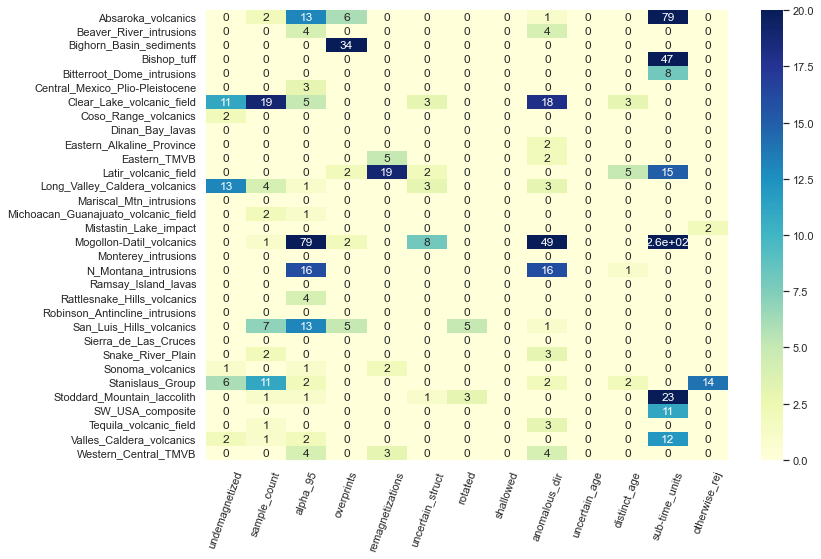

In [7]:
keys = ['undemagnetized','sample_count','alpha_95','overprints','remagnetizations','uncertain_struct','rotated','shallowed',
        'anomalous_dir','uncertain_age','distinct_age','sub-time_units','otherwise_rej']
values = [df_vgp_unfiltered.groupby(['Study'])[i].sum().tolist() for i in keys]

df_test = pd.DataFrame(columns = keys)
for key, value in zip(keys, values):
    df_test[key] = value
        
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(df_test, 
                 cmap="YlGnBu", yticklabels = df_vgp_unfiltered['Study'].unique(), annot = True, vmin = 0, vmax = 20)
ax.tick_params(axis='x', rotation=70)

### Set data inclusion criteria
Specify the inclusion criteria to be used in the data-selection. If author_selection is set=1, all other criteria will be ignored. Setting values other than 'None' for the remaining criteria allow them to be homogenized across studies.

In [38]:
def discard_vgps_recursively(df_vgps, max_angle):
    '''
    takes a group of vgps and discards iteratively those entries that lie "angle" degrees away from the recomputed mean
    '''
    if len(df_vgps) < 4:
        return df_vgps
    
    ppole = ipmag.fisher_mean(dec = df_vgps['vgp_lon_SH'].tolist(), inc = df_vgps['vgp_lat_SH'].tolist())       
    df_vgps['dist_2_mean'] = df_vgps.apply(lambda row: pmag.angle([row.vgp_lon_SH, row.vgp_lat_SH], [ppole['dec'], ppole['inc']]), axis=1)    
    max_angle_temp = df_vgps['dist_2_mean'].max()
    if max_angle_temp < max_angle: return df_vgps

    while max_angle_temp > max_angle:
        if len(df_vgps) < 4: return df_vgps
        df_vgps = df_vgps[df_vgps['dist_2_mean'] < max_angle]
        ppole = ipmag.fisher_mean(dec = df_vgps['vgp_lon_SH'].tolist(), inc = df_vgps['vgp_lat_SH'].tolist())       
        df_vgps['dist_2_mean'] = df_vgps.apply(lambda row: pmag.angle([row.vgp_lon_SH, row.vgp_lat_SH], [ppole['dec'], ppole['inc']]), axis=1)    
        max_angle_temp = df_vgps['dist_2_mean'].max()
        if max_angle_temp < max_angle: return df_vgps

In [8]:
def selection(df_unfiltered, incl_criteria):
    '''
    Pass an unfiltered DF of vgps and makes a subselection from a dictionary of criterias
    '''    
           
    df_unfiltered['keep'] = np.nan
        
    if incl_criteria['author_selection'] == True:        
        df_unfiltered['keep'] = df_unfiltered.apply(lambda row: True if row.in_study_pole != 0 else row.keep, axis = 1)
            
    for i in incl_criteria:                       
        if incl_criteria[i] == True:  # boolean cases          
            df_unfiltered['keep'] = df_unfiltered.apply(lambda row: True if row[i] == True else row.keep, axis = 1)
    
    if incl_criteria['sample_count']: df_unfiltered['keep'] = df_unfiltered.apply(lambda row: True if row['n'] >= incl_criteria['sample_count'] else row.keep, axis = 1)
    if incl_criteria['alpha_95']: df_unfiltered['keep'] = df_unfiltered.apply(lambda row: True if row['alpha95'] <= incl_criteria['alpha_95'] else row.keep, axis = 1)
    if incl_criteria['uncertain_age']: df_unfiltered['keep'] = df_unfiltered.apply(lambda row: True if row['age_uncertainty'] <= incl_criteria['uncertain_age'] else row.keep, axis = 1)
    if incl_criteria['rock_type']: df_unfiltered['keep'] = df_unfiltered.apply(lambda row: True if row['rock_typ_1'] == incl_criteria['rock_type'] else row.keep, axis = 1)
    
    # discard those discarded by other criterias
    for i in incl_criteria:        
        if incl_criteria[i] or i == 'rock_type': continue  # boolean cases
        df_unfiltered['keep'] = df_unfiltered.apply(lambda row: False if row[i] == True else row.keep, axis = 1)
            
    df_filtered = df_unfiltered.loc[df_unfiltered['keep'] == True]
    del df_unfiltered['keep']
    return df_filtered

In [37]:
# the basic dataset starts with the author selection
incl_criteria = {
    'author_selection': True,     # True or False; if 1, all other criteria will be ignored
    'undemagnetized': None,    # None (defaults to author selection) or True  
    'sample_count': None,      # None (defaults to author selection) or int: cutoff n (≥ x)
    'alpha_95': None,          # None (defaults to author selection) or float: cutoff A95 (≤ x degrees)
    'overprints': None,        # None (defaults to author selection) or True  
    'remagnetizations': None,  # None (defaults to author selection) or True
    'uncertain_struct': None,  # None (defaults to author selection) or True
    'rotated': None,           # None (defaults to author selection) or True
    'shallowed': None,         # None (defaults to author selection) or True [***can also implement cutoff f-value here if desired***]
    'anomalous_dir': None,     # None (defaults to author selection) or float: cutoff distance (in degrees) between vgp and mean (≤ x degrees)
    'uncertain_age': None,     # None (defaults to author selection) or float: cutoff age resolution (in Myr) between min and max (≤ x Myr)
    'distinct_age': None,      # None (defaults to author selection) or True
    'sub-time_units': True,    # None (defaults to author selection) or True (evaluates the dispersion of the supposed spot-readings)
    'rock_type': None,         # None (defaults to author selection) or string: 'all' or 'igneous' or 'sedimentary'
    'otherwise_rej': None     # None (defaults to author selection) or 'y'
    }

#### Filtering and selection of entries
First we select those entries based on booleand conditionals (e.g. include vgps that weren't demagnetized) and then we turn to select or discard those vgps based on nested conditionals (e.g. include or not anomalous directions xº apart from the mean, which implies first to compute a provitional PP, with also a potential recursive approach like Vandamme)

In [39]:
# Final DataFrame with the entries that follow all the specified criteria
df_vgp_compilation = pd.DataFrame(data = None, columns = df_vgp_unfiltered.columns)
df_pole_compilation = pd.DataFrame(data = None, columns = df_poles_original.columns)

# Boolean conditionals
df_selection = selection(df_vgp_unfiltered, incl_criteria)

# We have to iterate through the different studies to evaluate nested conditionals
for study, df_study in df_selection.groupby('Study'):
    
    # dim a DF to fill in with those entries that pass the criterias
    df_temp = pd.DataFrame(data = None, columns = df_selection.columns)

    # Strip age distinct (and send to the final DF), then, continue working with the subselection (this is independet of whether or not the criteria was applied)
    if not df_study[df_study['distinct_age'] == True].empty: 
        df_vgp_compilation = df_vgp_compilation.append(df_study[df_study['distinct_age'] == True]) # send the vgps with distinct directly to the final compilation since there is no reason to discard them from it.
        df_study = df_study[~df_study['distinct_age'] == True]
    
    # Group by synchronous units to evaluate if they represent the same spot reading or not (the same spot reading should have high concentration parameter -- to be setted e.g. higher than 150)
    for synch_unit, df_synch_unit in df_study.groupby('synch_unit'):
        
        if synch_unit == 0:
            df_temp = df_temp.append(df_synch_unit); continue
            
        if df_synch_unit.shape[0] > 1:
            synch_unit_mean = ipmag.fisher_mean(dec = df_synch_unit['vgp_lon_SH'].tolist(), inc = df_synch_unit['vgp_lat_SH'].tolist())                        
            if synch_unit_mean['k'] < 100:
                df_temp = df_temp.append(df_synch_unit)
            else:
                #print(study,synch_unit,"append the reported mean")
                df_temp = df_temp.append(df_synch_unit_means[df_synch_unit_means['synch_unit'] == "M" + str(synch_unit)]); continue
    
    if incl_criteria['anomalous_dir']: 
        df_temp = discard_vgps_recursively(df_temp, incl_criteria['anomalous_dir'])
         
    ppole = ipmag.fisher_mean(dec = df_temp['vgp_lon_SH'].tolist(), inc = df_temp['vgp_lat_SH'].tolist()) # final paleopole
    mean_site = ipmag.fisher_mean(dec = df_temp['slon'].tolist(), inc = df_temp['slat'].tolist())
    
    df_vgp_compilation = df_vgp_compilation.append(df_temp)
    df_pole_compilation = df_pole_compilation.append({'slat': mean_site['inc'], 'slon': mean_site['dec'], 'N': ppole['n'], 'Plat': ppole['inc'],
                                                                  'Plon': ppole['dec'], 'K': ppole['k'], 'A95': ppole['alpha95']}, ignore_index=True)
    
    #Now compute the final paleopole, determine its corresponding age, and append it to the re-calculated paleopole dataframe.
        
df_vgp_compilation.shape

(1305, 62)

#### In the following, we can visualize wich entries previously discarded by their authors are now included in the compilation.

(note that the inclusion of a criterion can lead to the inclusion of entries discarded for other reasons)

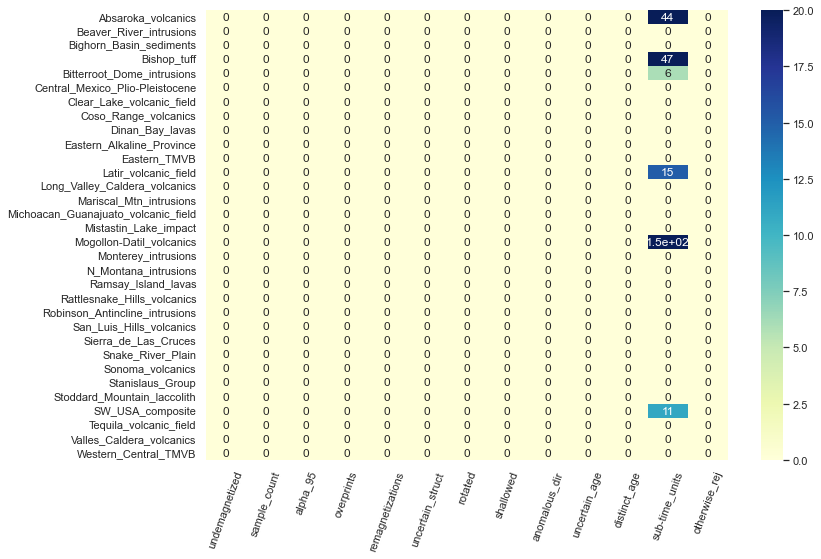

In [40]:
keys = ['undemagnetized','sample_count','alpha_95','overprints','remagnetizations','uncertain_struct','rotated','shallowed',
        'anomalous_dir','uncertain_age','distinct_age','sub-time_units','otherwise_rej']
values = [df_vgp_compilation.groupby(['Study'])[i].sum().tolist() for i in keys]

df_test = pd.DataFrame(columns = keys)
for key, value in zip(keys, values):
    df_test[key] = value
        
sns.set(rc={'figure.figsize':(11.7,8.27)})    
ax = sns.heatmap(df_test, 
                 cmap="YlGnBu", yticklabels = df_vgp_unfiltered['Study'].unique(), annot = True, vmin = 0, vmax = 20)
ax.tick_params(axis='x', rotation=70)